# Here's a "working" example of the new `get_data` functionality

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from climakitae.new_core.user_interface import ClimateData # a single import, nice!

In [2]:
# create your user interface
cd = ClimateData()

Initializing ClimateData...


## Exploring
Okay, so now you'll probably want to see what options are available to you and how to use it.

In [3]:
# list and demonstrate the "show_" methods
print("Available show_ methods:")
for method in dir(cd):
    if method.startswith("show_"):
        print(f"  {method}()")
        

Available show_ methods:
  show_activity_id_options()
  show_all_options()
  show_catalog_options()
  show_experiment_id_options()
  show_grid_label_options()
  show_installation_options()
  show_institution_id_options()
  show_processors()
  show_query()
  show_source_id_options()
  show_table_id_options()
  show_validators()
  show_variable_options()


## How the heck to do I get data out of this thing
There's a single function for getting data: `get()`

You just have to set up your configuration first, and then you can just call `.get()`.

And for your convenience, you can chain calls together just like `xarray` or `pandas` objects!

In [4]:
# let's look at a simple example where we just grab some photovoltaic data
data = (cd
    .catalog("renewables")
    .installation("pv_utility")
    .experiment_id("historical")
    .table_id("day")
    .grid_label("d03")
    .variable("cf")
    .get()
)

populating catalog keys
{'installation': 'pv_utility', 'experiment_id': 'historical', 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 'cf'}
Found 4 datasets matching the query: {'installation': 'pv_utility', 'experiment_id': 'historical', 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 'cf'}
Querying renewables catalog with query: {'installation': 'pv_utility', 'experiment_id': 'historical', 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 'cf'}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'installation.activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


# Subsetting
And now, since I don't want ALL of that data, let's subset it:

In [5]:
data = (cd
    .catalog("renewables")
    .installation("pv_utility")
    .experiment_id("historical")
    .table_id("day")
    .grid_label("d03")
    .variable("cf")
    .processes({
        "time_slice": ("2010-01-01", "2010-12-31"), # 2010 data
        "clip": ((36.04, 37.37), (-121.06, -121.43)) # Pajaro Valley
    }
    )
    .get()
)

populating catalog keys
{'installation': 'pv_utility', 'experiment_id': 'historical', 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 'cf'}
Found 4 datasets matching the query: {'installation': 'pv_utility', 'experiment_id': 'historical', 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 'cf'}
Querying renewables catalog with query: {'installation': 'pv_utility', 'experiment_id': 'historical', 'table_id': 'day', 'grid_label': 'd03', 'variable_id': 'cf'}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'installation.activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


## Well how can I tell it was modified?

Let's look at the attributes:

In [6]:
for k, v in data.items():
    for k2, v2 in v.attrs.items():
        print(f"{k2}: {v2}")

    print("="*40)
    print(v)
    break

Conventions: CF-1.8
experiment_id: historical
institution: Eagle Rock Analytics
institution_email: info@eaglerockanalytics.com
nominal_resolution: 3 km
panel_array_type: Single-axis tracking
panel_azimuth: 180 deg (south-facing)
panel_dc_ac_ratio: 1.3
panel_ground_coverage_ratio: 0.4
panel_inv_eff: 96%
panel_module_type: Standard
panel_nameplate_capacity: 100 MW
panel_tilt: N/A: Single-axis tracking
photovoltaic_installation_type: Utility
power_generation_model: Renewable Energy Potential (reV) v0.9.4 Zenodo. https://doi.org/10.5281/zenodo.12548947
power_generation_model_citation: Grant Buster, Michael Rossol, Paul Pinchuk, Brandon N Benton, Robert Spencer, Mike Bannister, & Travis Williams. (2023). NREL/reV: reV 0.8.0 (v0.8.0).)
source_id: WRF_EC-Earth3_r1i1p1f1
system_advisory_model: PVWattsv8
intake_esm_vars: ['cf']
intake_esm_attrs:installation: pv_utility
intake_esm_attrs:activity_id: WRF
intake_esm_attrs:institution_id: ERA
intake_esm_attrs:source_id: EC-Earth3
intake_esm_attrs:e

Where you can clearly see ^ that there are new attributes added from the pipeline telling you that the data has been subset.

## Prove it

Yeah, yeah, alright. Let's look at some plots

adding map features...


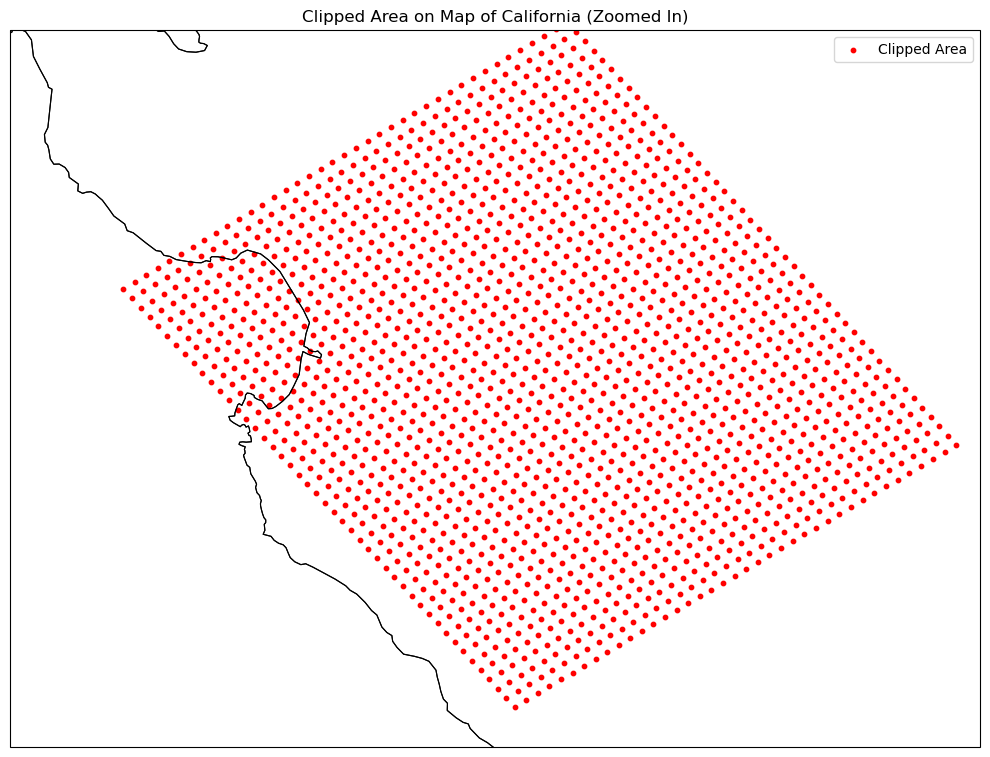

In [7]:
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# plot the clipped data
import matplotlib.pyplot as plt

key = list(data.keys())[0]
lon = data[key].lon.values
lat = data[key].lat.values

# Only plot the clipped region on a map of California, zoomed in
# California bounding box (zoomed in)
ca_lon_zoom = [-122.5, -120.2]
ca_lat_zoom = [35.8, 37.5]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

print("adding map features...")
ax.add_feature(cfeature.STATES.with_scale("10m"), edgecolor="black", linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

ax.set_title("Clipped Area on Map of California (Zoomed In)")
ax.set_xlim(ca_lon_zoom)
ax.set_ylim(ca_lat_zoom)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Plot the clipped grid points
ax.scatter(lon.flatten(), lat.flatten(), s=10, c='red', label='Clipped Area')

ax.legend()
plt.tight_layout()
plt.show()

## Okay hotshot, looks like you got clipping to work. But did you actually slice it?

Always check:

FrozenMappingWarningOnValuesAccess({'y': 46, 'x': 39, 'time': 365})


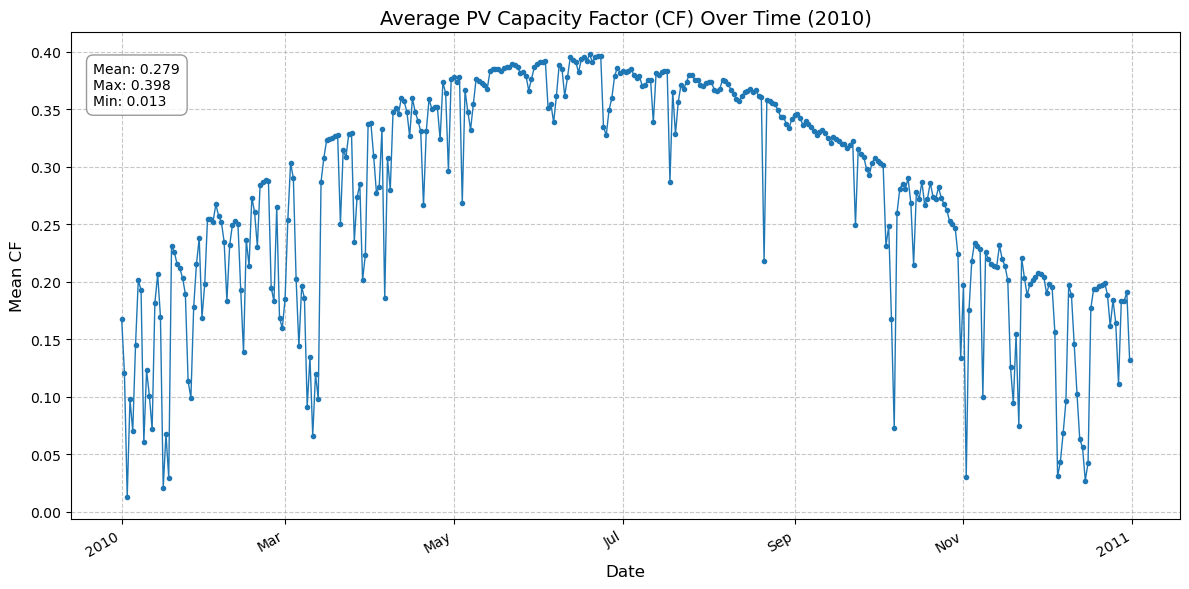

In [8]:
# demonstrate time slicing
# Get the first dataset from the clipped data
key = list(data.keys())[1]
ds = data[key]

print(ds.dims)

cf_time_series = ds['cf'].mean(dim=['x','y'])

# Create a time series plot
plt.figure(figsize=(12, 6))
cf_time_series.plot(marker='o', linestyle='-', linewidth=1, markersize=3)

plt.title('Average PV Capacity Factor (CF) Over Time (2010)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mean CF', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Format the x-axis date labels
plt.gcf().autofmt_xdate()

# Add statistics as text annotation
mean_cf = cf_time_series.mean().values
max_cf = cf_time_series.max().values
min_cf = cf_time_series.min().values

stats_text = f'Mean: {mean_cf:.3f}\nMax: {max_cf:.3f}\nMin: {min_cf:.3f}'
plt.annotate(stats_text, xy=(0.02, 0.85), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

## What else can it do?

Not much... yet. 

I'll probably do some merging next, so you can get a single dataframe back with multiple GCMs.

